In [2]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
import qiskit
from qiskit.circuit.library import StatePreparation
from qiskit import QuantumRegister, QuantumCircuit, Aer, transpile, ClassicalRegister
from qiskit.circuit.library import XGate, YGate, ZGate, HGate, TGate, IGate, CXGate, CZGate, SwapGate, CYGate
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
import random as rd

In [3]:
class QGym(gym.Env):
    
    def __init__(self, n_qubits=1):
        
        self.n_qubits = n_qubits

        self.quant_reg = QuantumRegister(self.n_qubits)
        self.quant_circuit = QuantumCircuit(self.quant_reg)
        
        self.quantum_gates = [
            XGate(),
            YGate(),
            ZGate(),
            IGate(),
            HGate(),
            TGate(),
            CXGate(),
            CZGate(),
            CYGate(),
            SwapGate()
            ]
        
        self.n_gates = 0
        
        self.action_space = spaces.MultiDiscrete([len(self.quantum_gates), 
                                                                self.n_qubits, 
                                                                self.n_qubits])
                                          
        self.observation_space = spaces.Box(0.00, 1.00, (1, 1), dtype=np.float32)
        
        self.c0 = 1
        self.c1 = -0.01
    
    def step(self, action):
        
        self.n_gates += 1
        gate = self.quantum_gates[action[0]]
        
        if action[1] == action[2]:
            action[2] == abs(action[1] - 1)
        
        if action[0] < 6:
            qubit = action[1]%self.n_qubits
            self.quant_circuit.append(gate, [qubit])
            
        else:
            if action[1] == action[2]:
                qubits = [action[1]%self.n_qubits, abs(action[1] - 1)%self.n_qubits]
                
            else:
                qubits = [action[1]%self.n_qubits, action[2]%self.n_qubits]
                
            self.quant_circuit.append(gate, qargs = qubits, cargs = None)
        
            
        sim = Aer.get_backend('statevector_simulator')
        result = sim.run(self.quant_circuit, shots=1).result().get_statevector()
        
        self.n_gates += 1
        
        self.fidelity = Statevector(result).probabilities()[-1]
        self.depth = self.quant_circuit.depth()
        
        observation = self.fidelity
        reward = self.get_score()
        terminated = False
        truncated = False
        info = {}
        
        if action[1] == action[2]:
            return observation, reward, terminated, truncated, [action[0], action[1],
                                                                     abs(action[1] - 1)]
        
        return observation, reward, terminated, truncated, [action[0], action[1],
                                                                     action[2]]
        
    def get_score(self):
        
        score = self.c0*self.fidelity + self.c1*self.depth
        return score
    
    
    def reset(self):
        
        self.quant_reg = QuantumRegister(self.n_qubits)
        self.quant_circuit = QuantumCircuit(self.quant_reg)
    
    def render(self):
        
        return self.quant_circuit.draw()
           

In [4]:
from gymnasium.envs.registration import register
register(
    id='QGym-v0',
    entry_point=QGym
)
env = gym.make('QGym-v0', n_qubits = 3)

In [ ]:
env.reset()

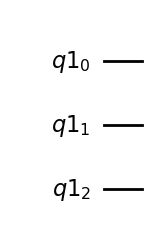

In [6]:
env.render()

Action:[8, 1, 0] Reward:-0.01
Action:[2, 1, 0] Reward:-0.02
Action:[2, 1, 0] Reward:-0.03
Action:[4, 0, 1] Reward:-0.03
Action:[8, 2, 0] Reward:-0.03
Action:[7, 0, 1] Reward:-0.04
Action:[6, 2, 1] Reward:-0.05
Action:[1, 0, 2] Reward:-0.05
Action:[0, 2, 1] Reward:-0.06
Action:[5, 0, 2] Reward:-0.06
Action:[8, 2, 0] Reward:-0.07
Action:[1, 1, 2] Reward:0.4299999999999999
Action:[5, 1, 0] Reward:0.42999999999999977
Action:[7, 2, 1] Reward:0.41999999999999976
Action:[6, 1, 0] Reward:0.4099999999999999
Action:[9, 0, 1] Reward:0.3999999999999999
Action:[7, 2, 1] Reward:0.3899999999999999
Action:[7, 2, 1] Reward:0.3799999999999999
Action:[7, 2, 1] Reward:0.3699999999999999
Action:[9, 1, 0] Reward:0.3599999999999999


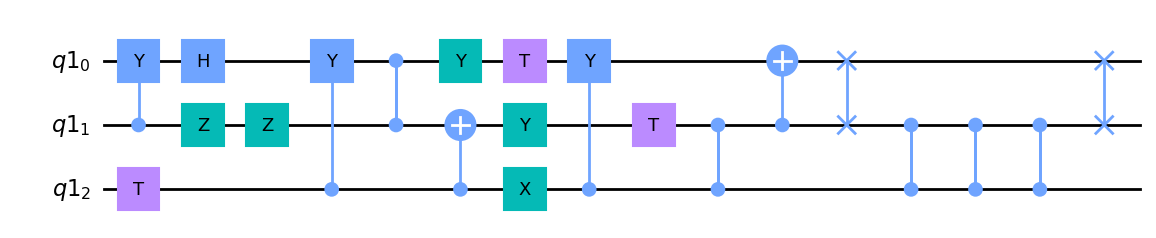

In [8]:
for i in range(20):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, action = env.step(action)
    print(f"Action:{action} Reward:{reward}")
env.render()
